In [7]:
import numpy as np
import pandas as pd
import os
import re
import shutil

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [8]:
IMG_FOLDER = 'images\\100px\Chargaff-Diversite-NucleScore'

IMG_SHAPE = (10, 10)

In [9]:
data = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = data.flow_from_directory(
	IMG_FOLDER,
	target_size=IMG_SHAPE,
	batch_size=32,
	class_mode='categorical',
	subset='training',
	shuffle=True
)
validation_generator = data.flow_from_directory(
	IMG_FOLDER,
	target_size=IMG_SHAPE,
	batch_size=32,
	class_mode='categorical',
	subset='validation',
	shuffle=True
)

Found 5419 images belonging to 5 classes.
Found 1352 images belonging to 5 classes.


In [10]:
# resize images from 2x2 to 32x32
# for i in range(len(train_generator.filenames)):
# 	img = Image.open(os.path.join(IMG_FOLDER, train_generator.filenames[i]))
# 	img_resized = img.resize((32, 32))
# 	# img_resized.show()  # Display the resized image without saving

# for i in range(len(validation_generator.filenames)):
# 	img = Image.open(os.path.join(IMG_FOLDER, validation_generator.filenames[i]))
# 	img_resized = img.resize((32, 32))
# 	# img_resized.show()  # Display the resized image without saving

In [11]:
# processing the classes
img_batch, labels_batch = next(train_generator)
print(img_batch.shape, labels_batch.shape)

data_labels = sorted(train_generator.class_indices.items(), key=lambda x: x[1])
data_labels = np.array([key.title() for key, value in data_labels])
print(data_labels)

(32, 10, 10, 3) (32, 5)
['East Asian' 'East-African Indian' 'Euro-American' 'Indo-Oceanic' '_M_']


In [12]:
# build a simple CNN model for image classification
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(10, 10, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(data_labels), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
history = model.fit(
	train_generator,
	steps_per_epoch=len(train_generator),
	validation_data=validation_generator,
	validation_steps=len(validation_generator),
	epochs=20,
	verbose=1
)

Epoch 1/20
170/170 [==============================] - 3s 14ms/step - loss: 1.0155 - accuracy: 0.6426 - val_loss: 0.9441 - val_accuracy: 0.6516
Epoch 2/20
170/170 [==============================] - 2s 13ms/step - loss: 0.7868 - accuracy: 0.7335 - val_loss: 0.5761 - val_accuracy: 0.8247
Epoch 3/20
170/170 [==============================] - 2s 13ms/step - loss: 0.4262 - accuracy: 0.8695 - val_loss: 0.4160 - val_accuracy: 0.8543
Epoch 4/20
170/170 [==============================] - 2s 13ms/step - loss: 0.3272 - accuracy: 0.8950 - val_loss: 0.3626 - val_accuracy: 0.8824
Epoch 5/20
170/170 [==============================] - 2s 14ms/step - loss: 0.2564 - accuracy: 0.9205 - val_loss: 0.3381 - val_accuracy: 0.8994
Epoch 6/20
170/170 [==============================] - 2s 14ms/step - loss: 0.2270 - accuracy: 0.9349 - val_loss: 0.3388 - val_accuracy: 0.9090
Epoch 7/20
170/170 [==============================] - 2s 14ms/step - loss: 0.2099 - accuracy: 0.9385 - val_loss: 0.3470 - val_accuracy: 0.9075

In [13]:
# evaluate the model on the test set
test_loss, test_acc = model.evaluate(validation_generator, steps=len(validation_generator))
print('Test accuracy:', test_acc)

43/43 [==============================] - 0s 10ms/step - loss: 0.2943 - accuracy: 0.9231
Test accuracy: 0.9230769276618958


In [14]:
model_predictions = model.predict(validation_generator, steps=len(validation_generator), verbose=1)
pred_dataframe = pd.DataFrame(model_predictions, columns=data_labels)
pred_dataframe.head()

43/43 [==============================] - 1s 11ms/step


,East Asian,East-African Indian,Euro-American,Indo-Oceanic,_M_
0,0.997791,0.001167,0.000950,9.227265e-05,1.226658e-08
1,0.000570,0.028966,0.639273,1.140638e-02,3.197845e-01
2,0.000066,0.000162,0.999771,6.825513e-08,6.604618e-07
3,0.000770,0.002502,0.996714,2.879863e-06,1.054058e-05
4,0.000963,0.005341,0.993412,5.637785e-05,2.280389e-04


In [ ]:

plt.figure(figsize=(20,18))
plt.subplots_adjust(hspace=0.5)

# get a few random test images and their predicted labels
for n in range(32):
	plt.subplot(10,10,n+1)
	plt.imshow(img_batch[n])
	plt.axis('off')
	color = "green" if np.argmax(labels_batch[n]) == np.argmax(model.predict(img_batch)[n]) else "red"
	plt.title(data_labels[np.argmax(model.predict(img_batch)[n])], color=color)
	plt.axis('off')
	_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

1/1 [==============================] - 0s 20ms/step


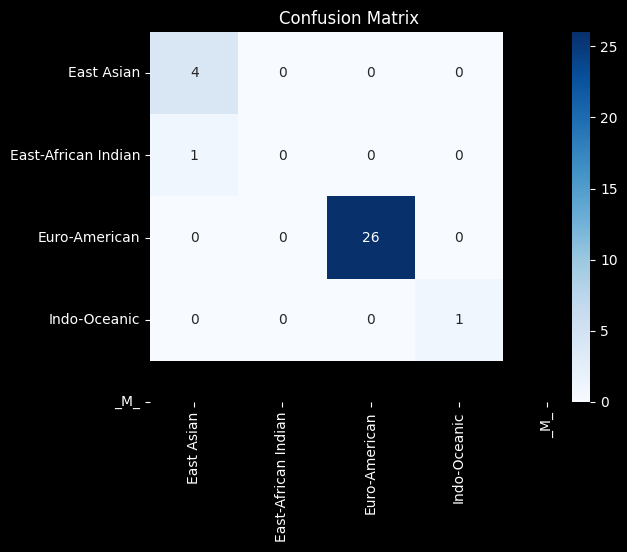

In [16]:
# confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

conf_matrix = confusion_matrix(np.argmax(labels_batch, axis=1), np.argmax(model.predict(img_batch), axis=1))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=data_labels, yticklabels=data_labels)
plt.title('Confusion Matrix')
plt.show()